In [6]:
import pandas as pd

# Load the dataset from the specified path
data = pd.read_csv(r'C:\Users\moham\Downloads\Mall_Customers.csv')
data.head()


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [7]:
#Inspecting the dataset

print(data.info())
print(data.describe())
print(data.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None
       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.750000
50%    100.500000   36.000000    

In [8]:
#Dropping unnecessary columns
data = data.drop(columns=['CustomerID'])


In [9]:
#Encode categorical columns
data['Gender'] = data['Gender'].map({'Male': 0, 'Female': 1})


In [10]:
#Select Features for Clustering
features = ['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']
X = data[features].copy()


In [11]:
#Scale features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


NEXT Step is to calculate the distance matrix and construct the MST(Minimum Spanning Tree) for fully preprocessed dataset.

In [12]:
# Compute pairwise distances
#Use the Euclidean distance metric to compute distances between all data points
from scipy.spatial.distance import pdist, squareform

# Compute Euclidean distance matrix (symmetric, n x n)
distance_matrix = squareform(pdist(X_scaled, metric='euclidean'))
print(distance_matrix)

[[0.         1.63681098 2.38878538 ... 4.54611614 4.81867651 5.02250496]
 [1.63681098 0.         3.54154808 ... 4.3182849  5.31878915 4.70189264]
 [2.38878538 3.54154808 0.         ... 5.42195122 5.13299938 5.90251765]
 ...
 [4.54611614 4.3182849  5.42195122 ... 0.         2.21418015 0.5647686 ]
 [4.81867651 5.31878915 5.13299938 ... 2.21418015 0.         2.5274803 ]
 [5.02250496 4.70189264 5.90251765 ... 0.5647686  2.5274803  0.        ]]


In [13]:
#Build the Graph and MST (using networkx)
#Each customer is a node. The edge weight between two nodes is their distance.
import networkx as nx

# Create an empty graph
G = nx.Graph()

# Add edges: each pair of customers (nodes) with their distance as weight
num_points = len(X_scaled)
for i in range(num_points):
    for j in range(i + 1, num_points):
        G.add_edge(i, j, weight=distance_matrix[i, j])

# Compute the MST (Kruskal's algorithm)
mst = nx.minimum_spanning_tree(G, weight='weight')
print("Number of nodes in MST:", mst.number_of_nodes())
print("Number of edges in MST:", mst.number_of_edges())

Number of nodes in MST: 200
Number of edges in MST: 199


In [14]:
# Reduce the component to 2D using principal component analysis (PCA)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)


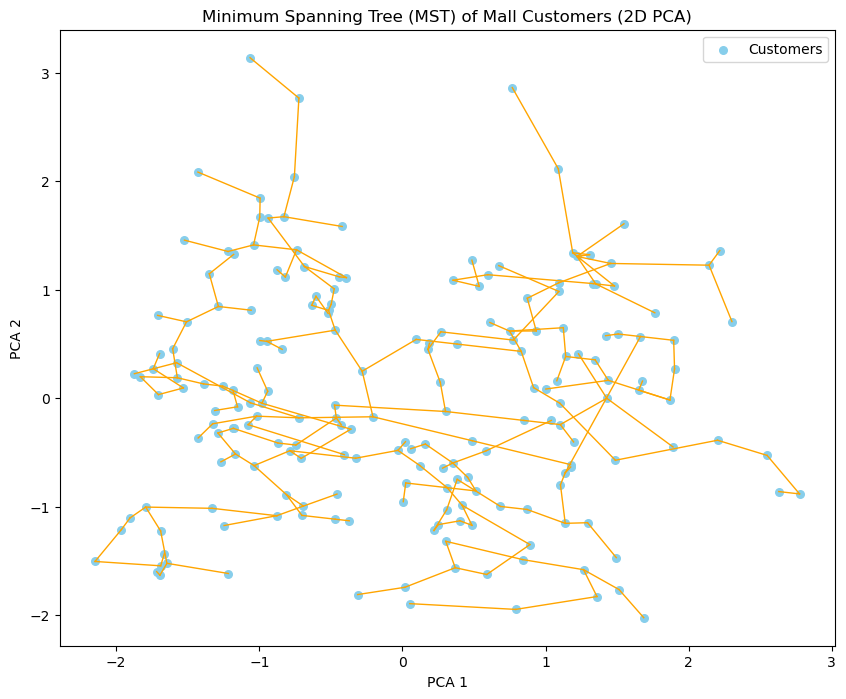

In [15]:
#Visualize the MST
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))

# Plot the data points
plt.scatter(X_2d[:,0], X_2d[:,1], c='skyblue', label='Customers', s=30)

# Overlay the MST edges
for edge in mst.edges():
    p1, p2 = edge
    x_coords = [X_2d[p1,0], X_2d[p2,0]]
    y_coords = [X_2d[p1,1], X_2d[p2,1]]
    plt.plot(x_coords, y_coords, color='orange', linewidth=1)

plt.title('Minimum Spanning Tree (MST) of Mall Customers (2D PCA)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.show()


MST for single-linkage hierarchical clustering by removing the largest edges to form clusters. 

In [16]:
#Decide the number of clusters by cutting the MST
k = 4

In [17]:
#Remove the largest k-1 edges from the MST to form k clusters
# Sort MST edges by weight, in descending order
edges_sorted = sorted(mst.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)

# Remove the k-1 largest edges to form k clusters
mst_cluster = mst.copy()
for i in range(k-1):
    edge_to_remove = (edges_sorted[i][0], edges_sorted[i][1])
    mst_cluster.remove_edge(*edge_to_remove)


In [18]:
#Assign cluster labels to each data point
clusters = list(nx.connected_components(mst_cluster))

# Create a label array matching each data point to its cluster
labels = [0] * len(X_scaled)
for idx, cluster in enumerate(clusters):
    for node in cluster:
        labels[node] = idx
print("Cluster labels for each data point:", labels)

Cluster labels for each data point: [0, 1, 2, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 1, 1, 3, 1, 1, 3, 1, 1, 3, 1, 3, 1, 3, 1, 3, 3, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 1, 1, 3, 3, 1, 1, 3, 3, 1, 3, 1, 3, 3, 3, 1, 1, 3, 1, 3, 3, 1, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 3, 3, 1, 1, 3, 3, 1, 1, 1, 3, 3, 1, 1, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 1, 1, 1, 1, 1, 1, 3, 3, 1, 3, 3, 1, 1, 3, 3, 1, 3, 3, 1, 1, 1, 3, 3, 1, 1, 1, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 1, 3, 1, 3, 1, 3, 3, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 1]


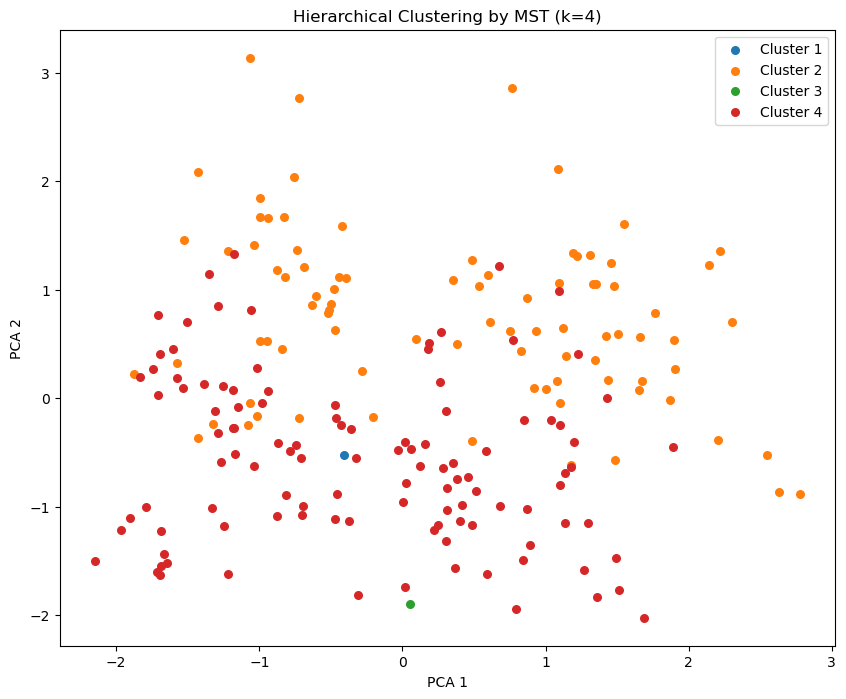

In [19]:
#Visualize cluster Assignments(with PCA coordinates)
import numpy as np
plt.figure(figsize=(10,8))
colors = plt.cm.tab10(np.arange(k))

for i in range(k):
    members = np.array([idx for idx, label in enumerate(labels) if label == i])
    plt.scatter(X_2d[members, 0], X_2d[members, 1], color=colors[i], label=f'Cluster {i+1}', s=30)

plt.title(f'Hierarchical Clustering by MST (k={k})')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.show()


###analyze the properties of each cluster to extract meaningful insights

In [20]:
#Attach cluster labels to original data
data['Cluster'] = labels
print(data.head())

   Gender  Age  Annual Income (k$)  Spending Score (1-100)  Cluster
0       0   19                  15                      39        0
1       0   21                  15                      81        1
2       1   20                  16                       6        2
3       1   23                  16                      77        3
4       1   31                  17                      40        3


In [21]:
#Summarize cluster properties
for i in range(k):
    subset = data[data['Cluster'] == i]
    print(f'\n--- Cluster {i+1} ---')
    print(f'Number of customers: {len(subset)}')
    print(f'Gender (Female %): {100*subset["Gender"].mean():.1f}%')
    print(f'Average Age: {subset["Age"].mean():.2f}')
    print(f'Average Annual Income: {subset["Annual Income (k$)"].mean():.2f}')
    print(f'Average Spending Score: {subset["Spending Score (1-100)"].mean():.2f}')



--- Cluster 1 ---
Number of customers: 1
Gender (Female %): 0.0%
Average Age: 19.00
Average Annual Income: 15.00
Average Spending Score: 39.00

--- Cluster 2 ---
Number of customers: 87
Gender (Female %): 0.0%
Average Age: 40.05
Average Annual Income: 62.77
Average Spending Score: 48.62

--- Cluster 3 ---
Number of customers: 1
Gender (Female %): 100.0%
Average Age: 20.00
Average Annual Income: 16.00
Average Spending Score: 6.00

--- Cluster 4 ---
Number of customers: 111
Gender (Female %): 100.0%
Average Age: 38.26
Average Annual Income: 59.64
Average Spending Score: 51.94


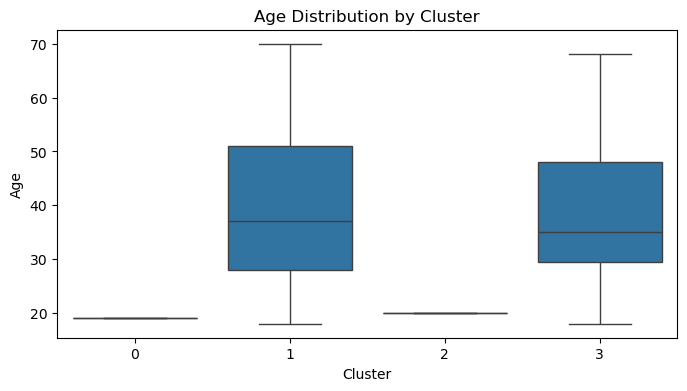

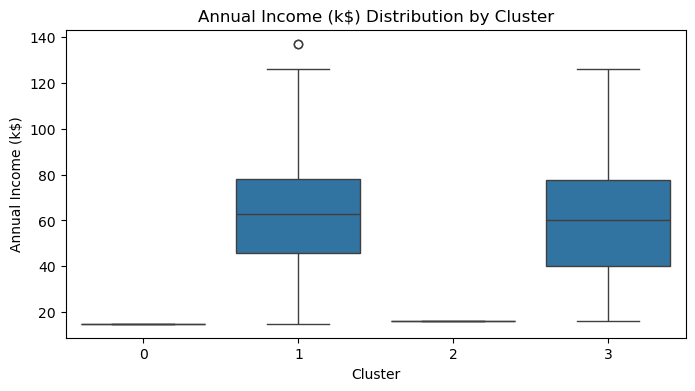

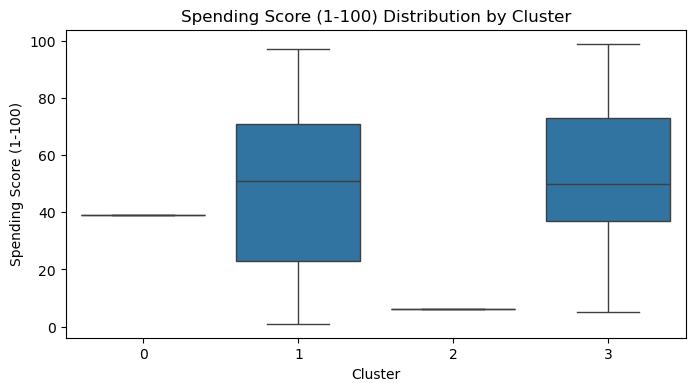

In [22]:
#Visualize the cluster Distributions
import seaborn as sns
import matplotlib.pyplot as plt

features_to_plot = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
for feature in features_to_plot:
    plt.figure(figsize=(8,4))
    sns.boxplot(x='Cluster', y=feature, data=data)
    plt.title(f'{feature} Distribution by Cluster')
    plt.show()


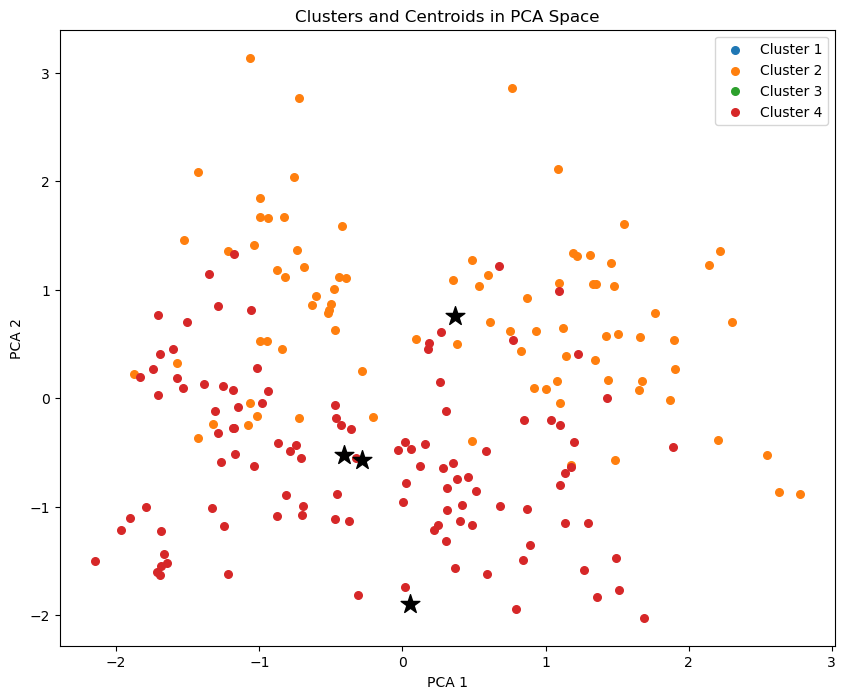

In [23]:
#Scatter plot
import numpy as np

plt.figure(figsize=(10,8))
for i in range(k):
    members = np.array([idx for idx, label in enumerate(labels) if label == i])
    plt.scatter(X_2d[members, 0], X_2d[members, 1], label=f'Cluster {i+1}', s=30)
    centroid = X_2d[members].mean(axis=0)
    plt.scatter(*centroid, color='black', marker='*', s=200)
plt.title('Clusters and Centroids in PCA Space')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.show()


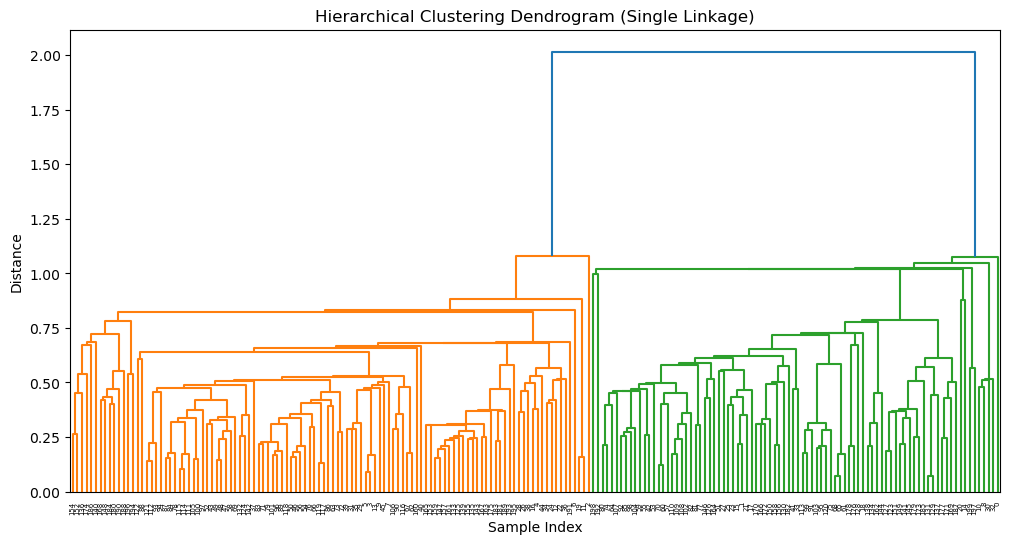

In [24]:
#Dendrogram Visualization
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Use the complete or single method for hierarchical clustering
linked = linkage(X_scaled, method='single', metric='euclidean')

plt.figure(figsize=(12, 6))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True,
           no_labels=False)
plt.title('Hierarchical Clustering Dendrogram (Single Linkage)')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()


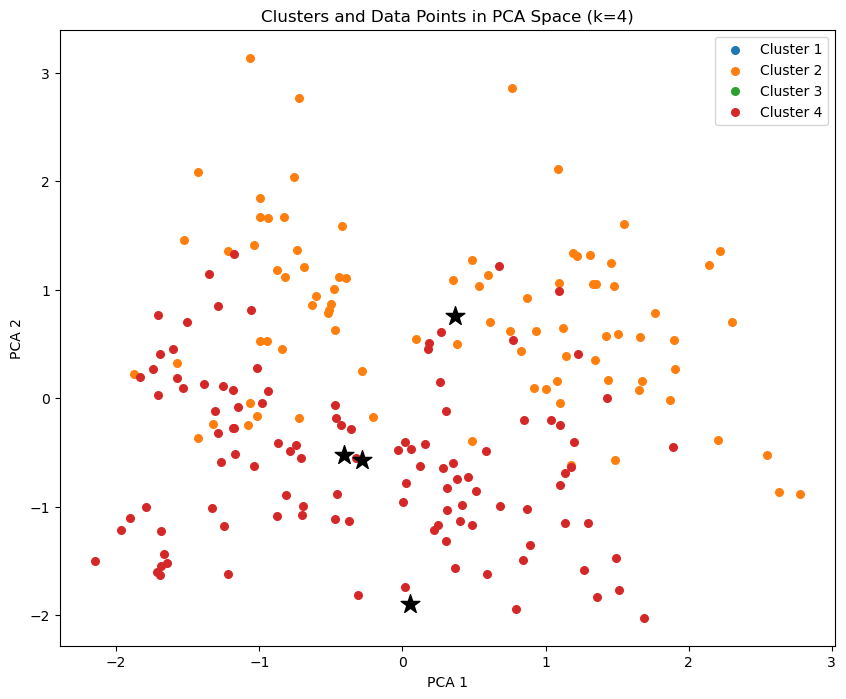

In [25]:
#Scatter plot in PCA space with cluster centroids
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,8))
colors = plt.cm.tab10(np.arange(k))

for i in range(k):
    members = np.array([idx for idx, label in enumerate(labels) if label == i])
    plt.scatter(X_2d[members, 0], X_2d[members, 1], color=colors[i], label=f'Cluster {i+1}', s=30)
    # Optional: Plot cluster centroid
    centroid = X_2d[members].mean(axis=0)
    plt.scatter(*centroid, color='black', marker='*', s=200)

plt.title(f'Clusters and Data Points in PCA Space (k={k})')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.show()


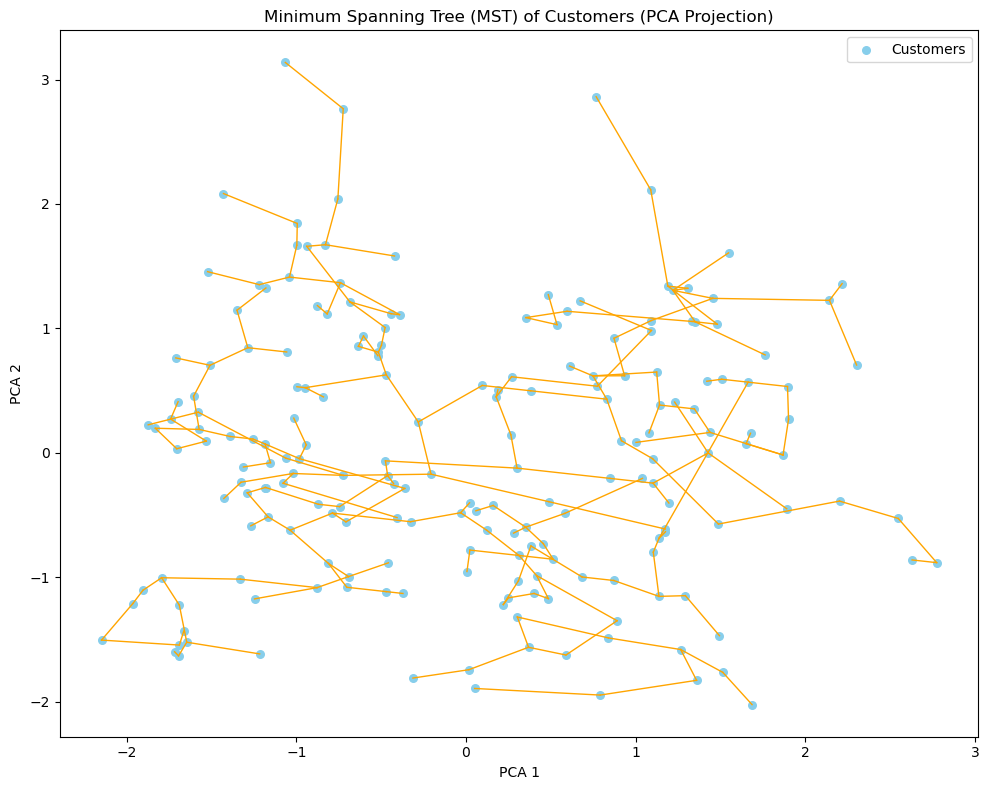

In [26]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

# Load and preprocess data
data = pd.read_csv(r'C:\Users\moham\Downloads\Mall_Customers.csv')
data = data.drop(columns=['CustomerID'])
data['Gender'] = data['Gender'].map({'Male': 0, 'Female': 1})
features = ['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']
X = data[features].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Distance and MST
distance_matrix = squareform(pdist(X_scaled, metric='euclidean'))
G = nx.Graph()
num_points = len(X_scaled)
for i in range(num_points):
    for j in range(i + 1, num_points):
        G.add_edge(i, j, weight=distance_matrix[i, j])
mst = nx.minimum_spanning_tree(G)

# PCA for 2D visualization
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)

# Plot MST overlay
plt.figure(figsize=(10,8))
plt.scatter(X_2d[:,0], X_2d[:,1], c='skyblue', label='Customers', s=30)
for edge in mst.edges():
    p1, p2 = edge
    x_coords = [X_2d[p1,0], X_2d[p2,0]]
    y_coords = [X_2d[p1,1], X_2d[p2,1]]
    plt.plot(x_coords, y_coords, color='orange', linewidth=1)
plt.title('Minimum Spanning Tree (MST) of Customers (PCA Projection)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.tight_layout()
plt.savefig('mst_customers.png', dpi=300)  # Save the image for your report
plt.show()


In [27]:
data['Cluster'] = labels


In [28]:
# Cluster Summary Statistics Table
summary = data.groupby('Cluster').agg(
    Size=('Cluster', 'count'),
    Avg_Age=('Age', 'mean'),
    Avg_Income=('Annual Income (k$)', 'mean'),
    Avg_Spending=('Spending Score (1-100)', 'mean'),
    Female_Pct=('Gender', lambda x: 100 * x.mean())  # Gender: Female as 1, Male as 0
).reset_index()

# Rename columns for clarity
summary = summary.rename(columns={'Female_Pct': 'Female (%)'})

print(summary)


   Cluster  Size    Avg_Age  Avg_Income  Avg_Spending  Female (%)
0        0     1  19.000000   15.000000     39.000000         0.0
1        1    87  40.045977   62.770115     48.620690         0.0
2        2     1  20.000000   16.000000      6.000000       100.0
3        3   111  38.261261   59.639640     51.936937       100.0


c:\Users\moham\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


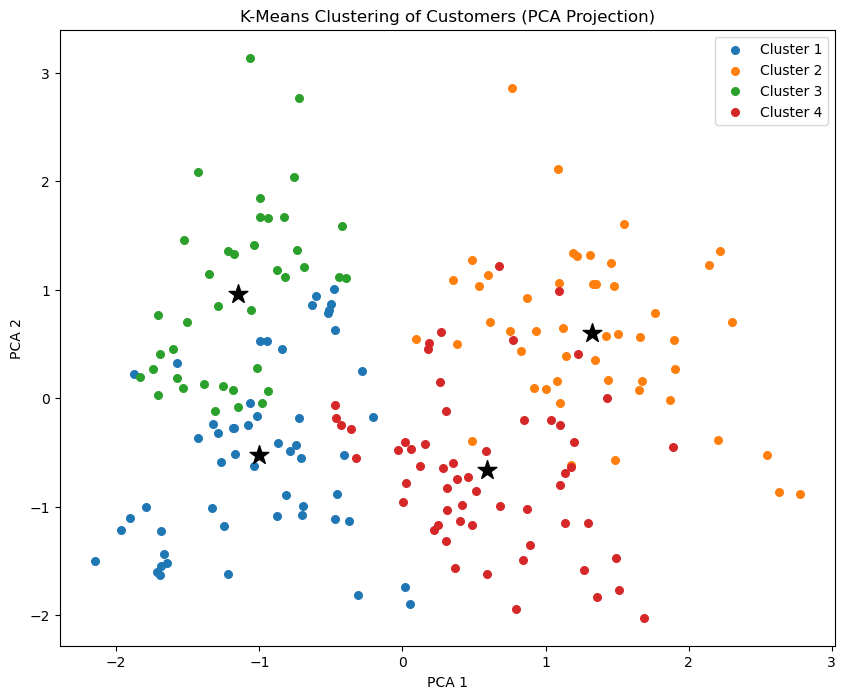

In [29]:
# K-Means Clustering and Visualization

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Fit K-Means (choose same number of clusters as MST for fair comparison, e.g., k=4)
k = 4
kmeans = KMeans(n_clusters=k, n_init=10, random_state=1)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Visualize K-Means clusters in PCA space
plt.figure(figsize=(10,8))
colors = plt.cm.tab10(np.arange(k))
for i in range(k):
    members = np.where(kmeans_labels == i)[0]
    plt.scatter(X_2d[members, 0], X_2d[members, 1], color=colors[i], label=f'Cluster {i+1}', s=30)
    centroid = kmeans.cluster_centers_[i]
    centroid_2d = PCA(n_components=2).fit(X_scaled).transform([centroid])[0]
    plt.scatter(*centroid_2d, color='black', marker='*', s=200)
plt.title('K-Means Clustering of Customers (PCA Projection)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.show()

# (Optional: Assign K-Means labels to dataframe for further analysis)
data['KMeans_Cluster'] = kmeans_labels


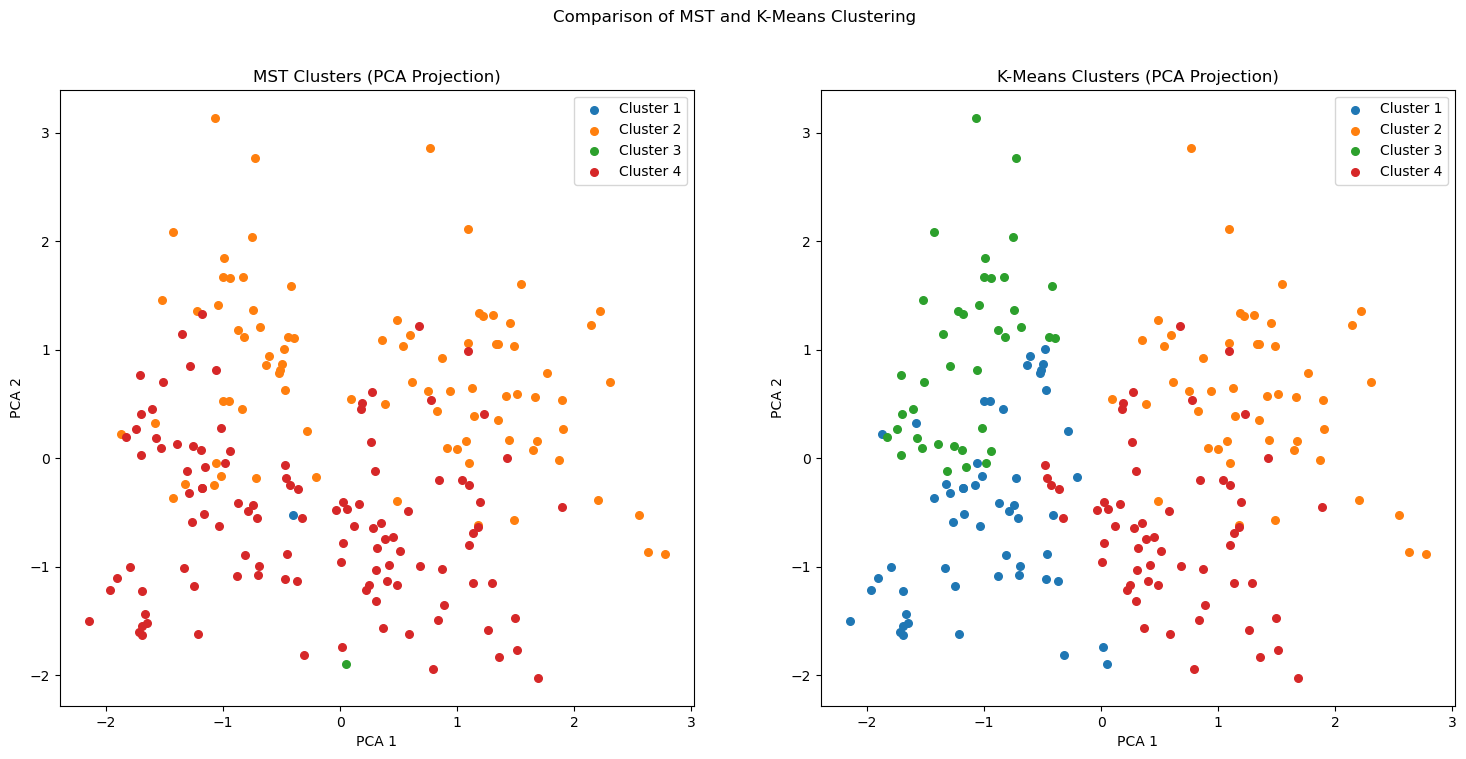

In [30]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(18,8))

# MST Clustering plot
for i in range(k):
    members = np.array([idx for idx, label in enumerate(labels) if label == i])
    axes[0].scatter(X_2d[members, 0], X_2d[members, 1], label=f'Cluster {i+1}', s=30)
axes[0].set_title('MST Clusters (PCA Projection)')
axes[0].set_xlabel('PCA 1')
axes[0].set_ylabel('PCA 2')
axes[0].legend()

# K-Means Clustering plot
for i in range(k):
    members = np.where(kmeans_labels == i)[0]
    axes[1].scatter(X_2d[members, 0], X_2d[members, 1], label=f'Cluster {i+1}', s=30)
axes[1].set_title('K-Means Clusters (PCA Projection)')
axes[1].set_xlabel('PCA 1')
axes[1].set_ylabel('PCA 2')
axes[1].legend()

plt.suptitle('Comparison of MST and K-Means Clustering')
plt.show()
